# Training Example

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import albumentations as A
from project.scripts.models import get_model
from project.scripts.viz_utils import show_image
import timm

## Training

In [5]:
num_classes = 16
num_epochs = 1

In [6]:
model = get_model('inception_v3.tv_in1k')

In [7]:
# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
model_transforms = timm.data.create_transform(**data_config, is_training=True)

In [8]:
transforms = A.Compose([
    A.Resize(height=300, width=300, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(p=0.2),  # use motion blur 
        A.MedianBlur(blur_limit=3, p=0.1),  # use median blur
        A.Blur(blur_limit=3, p=0.1),  # use blur
    ], p=0.2),
    A.OneOf([
        A.GaussNoise(),  # add gauss noise
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),  # shift scale rotate
    A.RandomBrightnessContrast(p=0.2),  # random brightness contrast
])

In [9]:
from project.scripts.augmentation import CoinDataset

dataset = CoinDataset(
    image_dir=os.path.join(os.getcwd(), 'train_annotated'),
    transform=transforms,
    preprocess=model_transforms
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


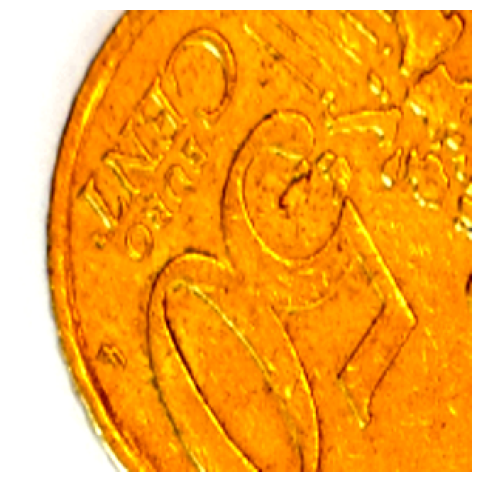

In [21]:
image, label = dataset[0]
_ = show_image(image.numpy().transpose(1, 2, 0))